In [1]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=False)
    rootpath = '/content/drive/My Drive/ai-side-projects/contrastive_learning_mnist/'
except:
    rootpath = './'
os.chdir(rootpath)

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from src import contrast_transforms, get_mnist_dataloaders, SimCLRLoss, simCLR_train, visualize_batch


LOAD_MODELS = True


%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device=='cuda':
    print(torch.cuda.get_device_properties(0).name)


cpu


NOTE THAT WE TRAIN ON 50% OF THE MNIST DATASET FOR SPEED
Train size: 21000
Validation size: 6000
Test size: 3000


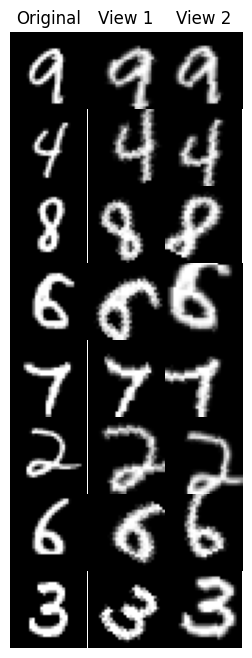

In [3]:
batch_size = 128

print('NOTE THAT WE TRAIN ON 50% OF THE MNIST DATASET FOR SPEED')
dataloader_train, _, dataloader_test = get_mnist_dataloaders(batch_size=batch_size, dataset_size=0.5)


visualize_batch(dataloader_train, n= 8, transform=contrast_transforms)

In [4]:
class EncoderCNN(nn.Module):

    def __init__(self, image_channels=1):
        super(EncoderCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 3, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(3, 6, kernel_size=2, stride=3),
            nn.ReLU(),
            nn.Flatten()
        )

    def forward(self, x):
        return self.encoder(x)


class ProjectionNN(nn.Module):

    def __init__(self, input_size=24, output_size=9):
        super(ProjectionNN, self).__init__()

        self.embedding = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.embedding(x)


class SimCLR(nn.Module):

    def __init__(self):
        super(SimCLR, self).__init__()

        self.encoder = EncoderCNN()
        self.projection = ProjectionNN()

    def forward(self, x):
        x = self.encoder(x)
        x = self.projection(x)
        return x


def test_shapes():
    model = SimCLR()

    x = torch.randn(1, 1, 28, 28)
    y_encoded = model.encoder(x)
    y_projected = model.projection(y_encoded)
    y = model(x)

    print(f"""
    input shape: {x.shape}
    encoded shape: {y_encoded.shape}
    projected shape: {y_projected.shape}
    output shape: {y.shape}
        """)
    
test_shapes()


    input shape: torch.Size([1, 1, 28, 28])
    encoded shape: torch.Size([1, 24])
    projected shape: torch.Size([1, 9])
    output shape: torch.Size([1, 9])
        


In [5]:

lr = 1e-1
temperature = 0.5

model = SimCLR().to(device)

if LOAD_MODELS:
    try:
        #vae.load_state_dict(torch.load('./models/vae'))
        if device == 'cuda':
            model.load_state_dict(torch.load('models/simclr'))
        if device == 'cpu':
            model.load_state_dict(torch.load('models/simclr', map_location=torch.device('cpu')))
        history = pd.read_csv('models/simclr_history.csv')
        #history to dict
        history = history.to_dict(orient='list')

    except:
        print('Could not load model')
        history = None
        pass



optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = SimCLRLoss(temperature=temperature, device=device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)



Could not load model


In [6]:
n_epochs = 10

history = simCLR_train(model, criterion, optimizer, scheduler=scheduler,
                           dataloader_train=dataloader_train, dataloader_val=None,
                           history=history,
                           epochs=n_epochs,
                           device=device)


Epochs: 100%|██████████| 10/10 [00:58<00:00,  5.83s/it, Loss=5.54008]

Model and history saved


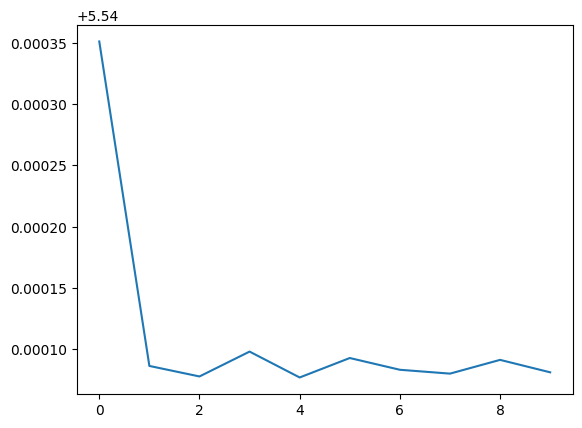

In [7]:
plt.plot(history['train_loss'])